In [1]:
# Import necessary libraries
import numpy as np 
import pandas as pd  
import matplotlib.pyplot as plt  
import seaborn as sns  

from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder  
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score  
from sklearn.metrics import confusion_matrix, classification_report  

import tensorflow as tf  
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense  

d:\Machine learning\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
# Load the dataset
df = pd.read_csv('House_Price_Prediction_Dataset.csv')

# Display dataset info
print("Dataset Shape:", df.shape)  # (13320, 9)
print("Column Names:", df.columns.tolist())
print("First Few Rows:\n", df.head())
print("Data Types:\n", df.dtypes)

Dataset Shape: (13320, 9)
Column Names: ['area_type', 'availability', 'location', 'size', 'society', 'total_sqft', 'bath', 'balcony', 'price']
First Few Rows:
               area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
Data Types:
 area_type        object
availability     object
location         objec

In [3]:
# Check missing values
print("Missing Values:\n", df.isnull().sum())

# Handle missing values
df['bath'] = df['bath'].fillna(df['bath'].median())  
df['balcony'] = df['balcony'].fillna(df['balcony'].median())  
df['size'] = df['size'].fillna(df['size'].mode()[0])  
df = df.dropna(subset=['location'])  
df = df.drop('society', axis=1)  

df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))

def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None

df['total_sqft'] = df['total_sqft'].apply(convert_sqft_to_num)
df = df.dropna(subset=['total_sqft']) 

print("Cleaned Missing Values:\n", df.isnull().sum())

Missing Values:
 area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64
Shape after removing duplicates: (12750, 8)
Cleaned Missing Values:
 area_type       0
availability    0
location        0
size            0
total_sqft      0
bath            0
balcony         0
price           0
bhk             0
dtype: int64


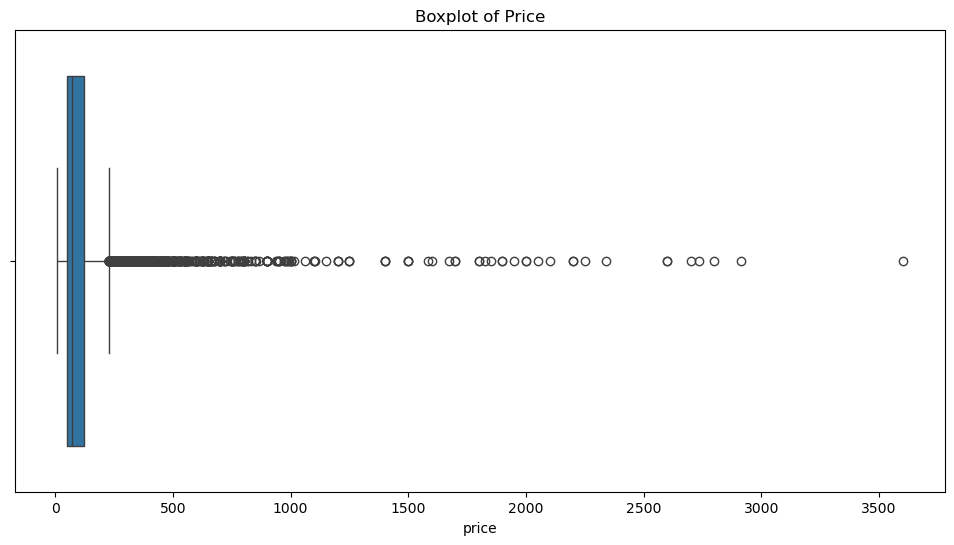

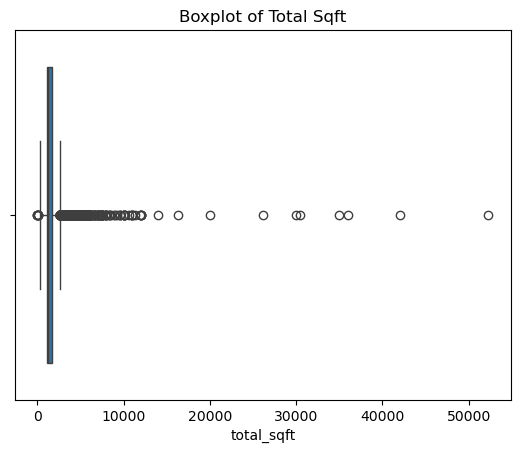

Shape after outlier removal: (10790, 9)


In [4]:
# Visualize outliers using boxplots
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['price'])
plt.title('Boxplot of Price')
plt.show()

sns.boxplot(x=df['total_sqft'])
plt.title('Boxplot of Total Sqft')
plt.show()

# IQR method for outlier removal (for price)
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['price'] >= (Q1 - 1.5 * IQR)) & (df['price'] <= (Q3 + 1.5 * IQR))]

# Similar for total_sqft and bhk
Q1_sqft = df['total_sqft'].quantile(0.25)
Q3_sqft = df['total_sqft'].quantile(0.75)
IQR_sqft = Q3_sqft - Q1_sqft
df = df[(df['total_sqft'] >= (Q1_sqft - 1.5 * IQR_sqft)) & (df['total_sqft'] <= (Q3_sqft + 1.5 * IQR_sqft))]

print("Shape after outlier removal:", df.shape)

In [4]:
# Label Encoding for availability (binary-like)
le = LabelEncoder()
df['availability'] = le.fit_transform(df['availability'])

df['location'] = df['location'].apply(lambda x: x.strip())
location_stats = df['location'].value_counts()
location_stats_less_than_10 = location_stats[location_stats <= 10]
df['location'] = df['location'].apply(lambda x: 'other' if x in location_stats_less_than_10 else x)

df = pd.get_dummies(df, columns=['area_type', 'location'], drop_first=True)

df = df.drop(['size'], axis=1)

scaler = StandardScaler()
numeric_features = ['total_sqft', 'bath', 'balcony', 'bhk']
df[numeric_features] = scaler.fit_transform(df[numeric_features])

print("Scaled Data Sample:\n", df.head())


Scaled Data Sample:
    availability  total_sqft      bath   balcony   price       bhk  \
0            40   -0.407952 -0.520623 -0.746924   39.07 -0.623998   
1            80    0.815906  1.695120  1.728339  120.00  0.902825   
2            80   -0.103573 -0.520623  1.728339   62.00  0.139414   
3            80   -0.039368  0.217958 -0.746924   95.00  0.139414   
4            80   -0.293810 -0.520623 -0.746924   51.00 -0.623998   

   area_type_Carpet  Area  area_type_Plot  Area  \
0                   False                 False   
1                   False                  True   
2                   False                 False   
3                   False                 False   
4                   False                 False   

   area_type_Super built-up  Area  location_1st Phase JP Nagar  ...  \
0                            True                        False  ...   
1                           False                        False  ...   
2                           False           

In [5]:
# Split features and target
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train Shape:", X_train.shape)
print("Test Shape:", X_test.shape)

Train Shape: (10163, 240)
Test Shape: (2541, 240)


In [6]:
# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2. Decision Tree
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# 3. Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 4. SVR
svr = SVR()
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# 5. Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

C:\Users\soohj\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


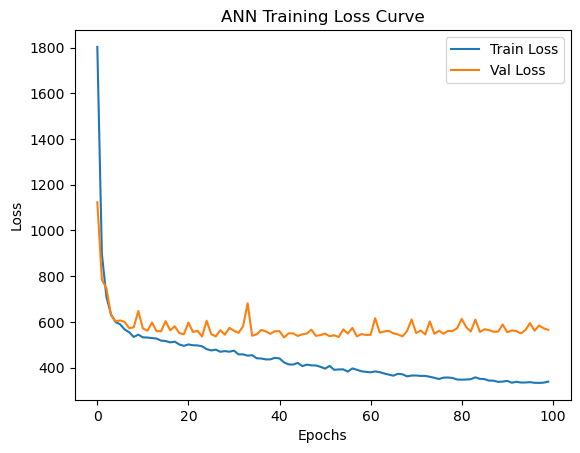

In [8]:
# Build ANN
model = Sequential()
model.add(Dense(200, input_dim=X_train.shape[1], activation='relu')) 
model.add(Dense(100, activation='relu')) 
model.add(Dense(50, activation='relu'))  
model.add(Dense(1, activation='linear')) 

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')  

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

# Predict
y_pred_ann = model.predict(X_test).flatten()

# Visualize training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('ANN Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}")
    return [mae, mse, rmse, r2]

# Evaluate all
results = {}
results['Linear Regression'] = evaluate_model(y_test, y_pred_lr, 'Linear Regression')
results['Decision Tree'] = evaluate_model(y_test, y_pred_dt, 'Decision Tree')
results['Random Forest'] = evaluate_model(y_test, y_pred_rf, 'Random Forest')
results['SVR'] = evaluate_model(y_test, y_pred_svr, 'SVR')
results['Gradient Boosting'] = evaluate_model(y_test, y_pred_gb, 'Gradient Boosting')
results['ANN'] = evaluate_model(y_test, y_pred_ann, 'ANN')

# Comparison Table
results_df = pd.DataFrame(results, index=['MAE', 'MSE', 'RMSE', 'R²']).T
print("Model Comparison:\n", results_df)

Linear Regression - MAE: 45.67, MSE: 13365.35, RMSE: 115.61, R²: 0.52
Decision Tree - MAE: 44.22, MSE: 20866.42, RMSE: 144.45, R²: 0.25
Random Forest - MAE: 37.23, MSE: 12156.16, RMSE: 110.25, R²: 0.56
SVR - MAE: 67.22, MSE: 29100.43, RMSE: 170.59, R²: -0.05
Gradient Boosting - MAE: 40.54, MSE: 12123.39, RMSE: 110.11, R²: 0.56


NameError: name 'y_pred_ann' is not defined

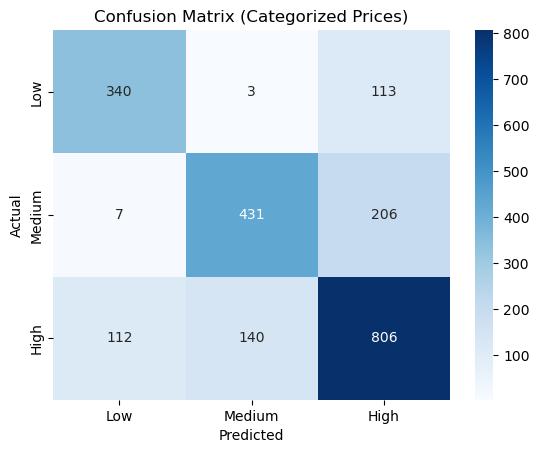

              precision    recall  f1-score   support

        High       0.74      0.75      0.74       456
         Low       0.75      0.67      0.71       644
      Medium       0.72      0.76      0.74      1058

    accuracy                           0.73      2158
   macro avg       0.74      0.73      0.73      2158
weighted avg       0.73      0.73      0.73      2158



In [10]:
# Categorize actual and predicted (using best model, e.g., Random Forest)
bins = [0, 50, 100, np.inf]
labels = ['Low', 'Medium', 'High']
y_test_cat = pd.cut(y_test, bins=bins, labels=labels)
y_pred_cat = pd.cut(y_pred_rf, bins=bins, labels=labels)

# Confusion Matrix
cm = confusion_matrix(y_test_cat, y_pred_cat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Categorized Prices)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(classification_report(y_test_cat, y_pred_cat))

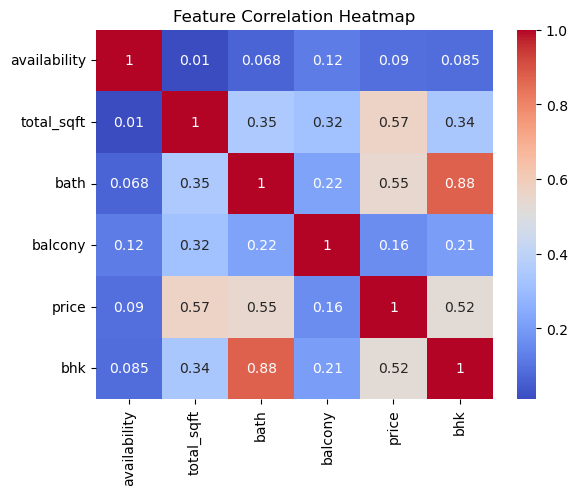

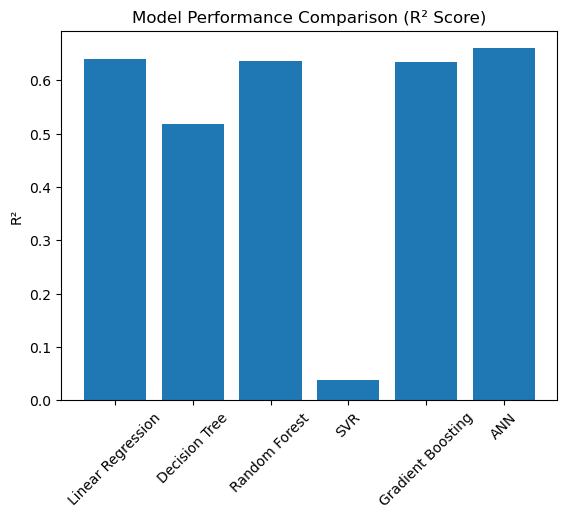

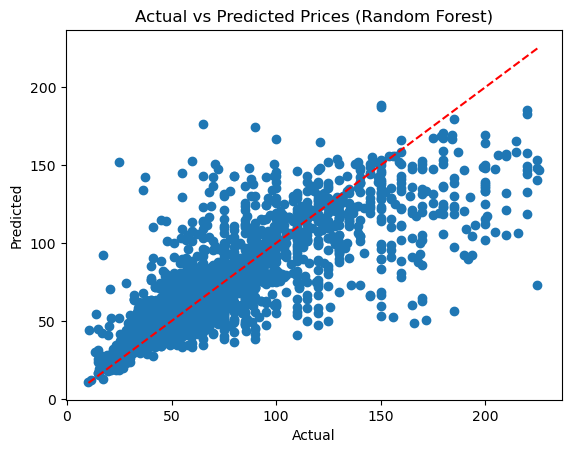

In [ ]:
# Heatmap: Feature Correlation
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Bar Graph: Model Performance (R²)
plt.bar(results_df.index, results_df['R²'])
plt.title('Model Performance Comparison (R² Score)')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.show()

# Actual vs Predicted (Random Forest)
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Prices (Random Forest)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


In [ ]:
# Model Comparison
results_df = pd.DataFrame(results).T  

results_df = results_df.round(2)  

display(results_df.sort_values(results_df.columns[-1], ascending=False))

best_model = results_df.iloc[:, -1].idxmax()  
print(f"The best algorithm is {best_model} with score = {results_df.loc[best_model, results_df.columns[-1]]:.2f}")

,0,1,2,3
ANN,15.65,576.34,24.01,0.66
Linear Regression,17.22,608.96,24.68,0.64
Random Forest,15.90,617.75,24.85,0.64
Gradient Boosting,17.56,619.31,24.89,0.63
Decision Tree,18.12,815.75,28.56,0.52
SVR,28.48,1630.73,40.38,0.04


The best algorithm is ANN with score = 0.66
